In [1]:
import json
import numpy as np
import random
import sys
from tqdm import tqdm
import re
from pathlib import Path

import torch
import torch.nn as nn
from transformers import DistilBertModel, DistilBertTokenizer

from wikidataintegrator import wdi_core
from wikidata.client import Client
import wikidata
import en_core_web_sm
nlp = en_core_web_sm.load()

from IPython.display import clear_output
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
%matplotlib inline

#############################################################
from utils import get_triplets_by_idd, get_description_name
from datasets import load_rubq, load_simple_questions, combined_dataset
from models import EncoderBERT, get_projection_module_simple, get_tokenizer
from reject import reject_by_metric
from train import train_ensemble
from eval_models import eval_ensemble

%load_ext autoreload
%autoreload 1

2022-08-03 11:38:27.602652: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-03 11:38:27.607150: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-08-03 11:38:27.607175: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(m

In [2]:
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
print(device)

cuda:5


### Loading Graph Embeddings and Questions

In [3]:
#path to full list of embeddings and full list of ids (one2one correspondence with embeddings)
PATH_TO_EMBEDDINGS_Q = "../new_data/entitie_embeddings_ru.json" 
PATH_TO_IDS = "../new_data/entitie_ids_ru_filtered.json"
PATH_TO_EMBEDDINGS_P = "../new_data/entitie_P_embeddings_ru.json" 

graph_embeddings_Q = json.load(open(PATH_TO_EMBEDDINGS_Q))
graph_embeddings_P = json.load(open(PATH_TO_EMBEDDINGS_P))

In [4]:
%autoreload

MASTER_SEED = 42

questions_train, relations_train, entities_train, answers_train, questions_val, relations_val, entities_val, answers_val, questions_test, answers_test = load_rubq(MASTER_SEED, graph_embeddings_Q, graph_embeddings_P)
simple_questions_train, simple_questions_val = load_simple_questions(MASTER_SEED, graph_embeddings_Q, graph_embeddings_P)

/notebook/meker/KBQA/datasets.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  answers_train = np.array(answers)[train_ids]
/notebook/meker/KBQA/datasets.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  answers_val = np.array(answers)[val_ids]


308
296
1186
16414


100% 16414/16414 [00:00<00:00, 183662.91it/s]

8327


### Dataset and Dataloaders

In [5]:
%autoreload

train_dataset = combined_dataset(questions_train, answers_train, entities_train, relations_train, graph_embeddings_Q, graph_embeddings_P, simple_questions_train, device)
val_dataset = combined_dataset(questions_val, answers_val, entities_val, relations_val, graph_embeddings_Q, graph_embeddings_P, simple_questions_val, device)

val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=64, shuffle=False)

### Training loop

In [6]:
loss = nn.CosineEmbeddingLoss()
loss_name = str(loss)[:-2]
proj_hidden_size = 512

models_path = Path(f'./models/{loss_name}_{proj_hidden_size}_no_regularization/')
models_path.mkdir(parents=True, exist_ok=True)

In [7]:
# N_EPOCHS = 10
# N_MODELS = 5
# proj_hidden_size = 512

# train_ensemble(N_MODELS, N_EPOCHS, proj_hidden_size, train_dataset, val_dataloader, models_path, device):

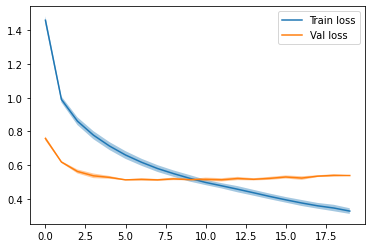

In [8]:
N_EPOCHS = 20

train_losses = []
val_losses = []

for i in range(5):
    train_losses.append(np.load(models_path / f'train_loss_{i}.npy'))
    val_losses.append(np.load(models_path / f'val_loss_{i}.npy'))

mean_train_loss = np.mean(train_losses, axis=0)
std_train_loss = np.std(train_losses, axis=0)

mean_val_loss = np.mean(val_losses, axis=0)
std_val_loss = np.std(val_losses, axis=0)

plt.plot(list(range(N_EPOCHS)), mean_train_loss, label='Train loss')
plt.fill_between(list(range(N_EPOCHS)), mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, alpha=0.4)
plt.plot(list(range(N_EPOCHS)), mean_val_loss, label='Val loss')
plt.fill_between(list(range(N_EPOCHS)), mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.4)

plt.legend()
plt.show()

### Load pretrained model

In [9]:
%autoreload

N_MODELS = 5
proj_hidden_size = 512

models = []
for i in range(N_MODELS):
    encoder = EncoderBERT(device)
    projection_E = get_projection_module_simple(device, proj_hidden_size)
    projection_Q = get_projection_module_simple(device, proj_hidden_size)
    projection_P = get_projection_module_simple(device, proj_hidden_size)

    encoder.load_state_dict(torch.load(models_path / f'encoder_{i}.pt'))
    projection_E.load_state_dict(torch.load(models_path / f'projection_E_{i}.pt'))
    projection_Q.load_state_dict(torch.load(models_path / f'projection_Q_{i}.pt'))
    projection_P.load_state_dict(torch.load(models_path / f'projection_P_{i}.pt'))
    
    models.append({'encoder': encoder, 'projection_P': projection_P, 'projection_Q': projection_Q, 'projection_E': projection_E})

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.Laye

## Eval

### RuBQ

In [10]:
embeddings_Q = graph_embeddings_Q
ids_list = list(graph_embeddings_Q.keys())
embeddings_Q = [embeddings_Q[Q] for Q in ids_list]
embeddings_tensor_Q = torch.FloatTensor(embeddings_Q)

embeddings_P = graph_embeddings_P
embeddings_P = [embeddings_P[P] for P in graph_embeddings_P.keys()]
embeddings_tensor_P = torch.FloatTensor(embeddings_P)

candidates = list(np.load("./data/presearched_fixed_rubq_test.npy", allow_pickle=True))

### Eval ensemble

In [11]:
%autoreload

q_list, a_list, a_predicts, inv_ranks, top1_scores, top2_scores, e_stds, q_stds, p_stds, e_stds_norm, q_stds_norm, p_stds_norm, cosines_stds, entropies_of_mean, mean_entropies, acc, cosines_P_stds, cosines_Q_stds, cosines_E_stds, bad_question_ids, all_cosines, a_model_predicts = eval_ensemble(questions_test, answers_test, graph_embeddings_P, graph_embeddings_Q, candidates, models, device, temperature=0.05)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/notebook/meker/KBQA/models.py:26: UserWarning: To copy construct

Accuracy:  0.4881956155143339


In [12]:
mask = np.full_like(a_predicts, True)
mask[bad_question_ids] = False
mask = mask.astype(bool)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


### Now with score-based rejection

In [13]:
from reject import reject_by_metric

%autoreload

recalls = np.flip(np.linspace(0.01, 1.0, 100))
rubq_score_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(top1_scores)[mask], recalls, reverse_order=True)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


### Now with delta-based rejection

In [14]:
top1_scores = np.array(top1_scores)
top2_scores = np.array(top2_scores)
delta = top1_scores - top2_scores

recalls = np.flip(np.linspace(0.01, 1.0, 100))
rubq_delta_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(delta)[mask], recalls, reverse_order=True)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


### StD of embeddings

In [15]:
recalls = np.flip(np.linspace(0.01, 1.0, 100))

total_stds = np.array([e_stds, p_stds, q_stds]).mean(axis=0)

rubq_e_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(e_stds)[mask], recalls)
rubq_p_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(p_stds)[mask], recalls)
rubq_q_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(q_stds)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must 

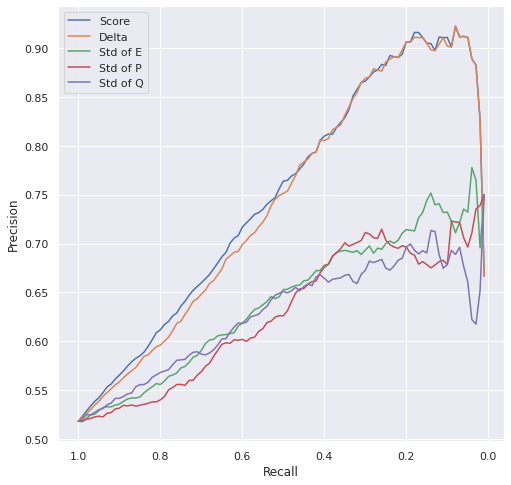

In [16]:
import seaborn as sns
sns.set_theme()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, rubq_score_accs, label='Score')
ax.plot(recalls, rubq_delta_accs, label='Delta')
ax.plot(recalls, rubq_e_accs, label='Std of E')
ax.plot(recalls, rubq_p_accs, label='Std of P')
ax.plot(recalls, rubq_q_accs, label='Std of Q')
ax.invert_xaxis()
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()

### StD of Normalized embeddings

In [17]:
recalls = np.flip(np.linspace(0.01, 1.0, 100))

rubq_e_accs_norm = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(e_stds_norm)[mask], recalls)
rubq_p_accs_norm = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(p_stds_norm)[mask], recalls)
rubq_q_accs_norm = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(q_stds_norm)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

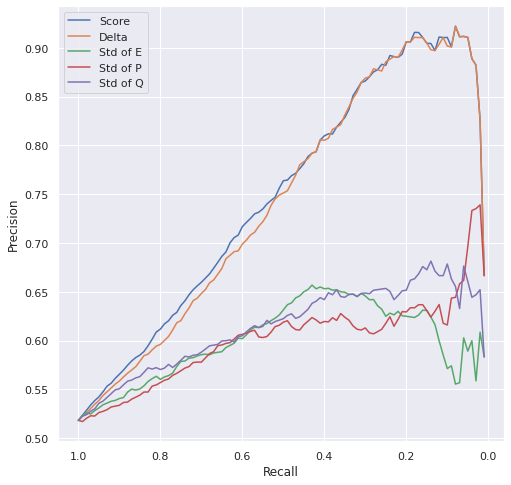

In [18]:
import seaborn as sns
sns.set_theme()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, rubq_score_accs, label='Score')
ax.plot(recalls, rubq_delta_accs, label='Delta')
ax.plot(recalls, rubq_e_accs_norm, label='Std of E')
ax.plot(recalls, rubq_p_accs_norm, label='Std of P')
ax.plot(recalls, rubq_q_accs_norm, label='Std of Q')
ax.invert_xaxis()
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()

### StD of scores

In [19]:
recalls = np.flip(np.linspace(0.01, 1.0, 100))

rubq_cosine_e_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(cosines_E_stds)[mask], recalls)
rubq_cosine_p_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(cosines_P_stds)[mask], recalls)
rubq_cosine_q_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(cosines_Q_stds)[mask], recalls)
rubq_cosine_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(cosines_stds)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

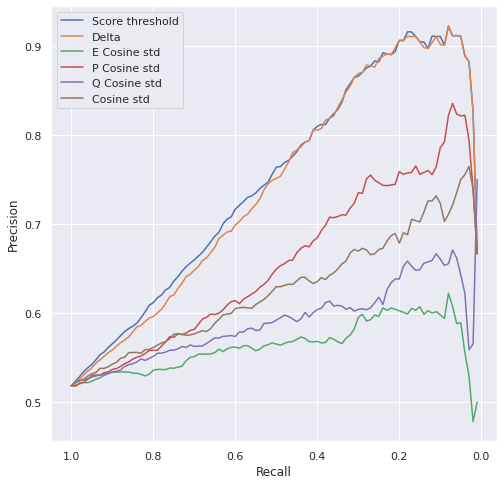

In [20]:
import seaborn as sns
sns.set_theme()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, rubq_score_accs, label='Score threshold')
ax.plot(recalls, rubq_delta_accs, label='Delta')
ax.plot(recalls, rubq_cosine_e_accs, label='E Cosine std')
ax.plot(recalls, rubq_cosine_p_accs, label='P Cosine std')
ax.plot(recalls, rubq_cosine_q_accs, label='Q Cosine std')
ax.plot(recalls, rubq_cosine_accs, label='Cosine std')
ax.invert_xaxis()
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()

### Hamming distance

In [21]:
from scipy.spatial.distance import hamming
from itertools import combinations

distances = []

for model_preds in np.array(a_model_predicts)[mask]:
    pred_distances = []
    for i, j in combinations(range(5), 2):
        pred_distances.append(hamming(model_preds[i], model_preds[j]))
    distances.append(np.mean(pred_distances))

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [22]:
recalls = np.flip(np.linspace(0.01, 1.0, 100))

rubq_hamming_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], distances, recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


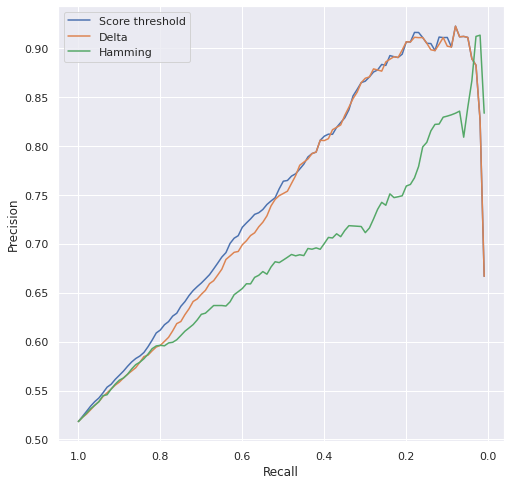

In [23]:
import seaborn as sns
sns.set_theme()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, rubq_score_accs, label='Score threshold')
ax.plot(recalls, rubq_delta_accs, label='Delta')
ax.plot(recalls, rubq_hamming_accs, label='Hamming')
ax.invert_xaxis()
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()

#### Limit Hamming to 10 preds

In [24]:
from scipy.spatial.distance import hamming
from itertools import combinations

distances_10 = []

for model_preds in np.array(a_model_predicts)[mask]:
    pred_distances = []
    for i, j in combinations(range(5), 2):
        pred_distances.append(hamming(model_preds[i][:10], model_preds[j][:10]))
    distances_10.append(np.mean(pred_distances))

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [25]:
recalls = np.flip(np.linspace(0.01, 1.0, 100))

rubq_hamming_accs_10 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], distances_10, recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


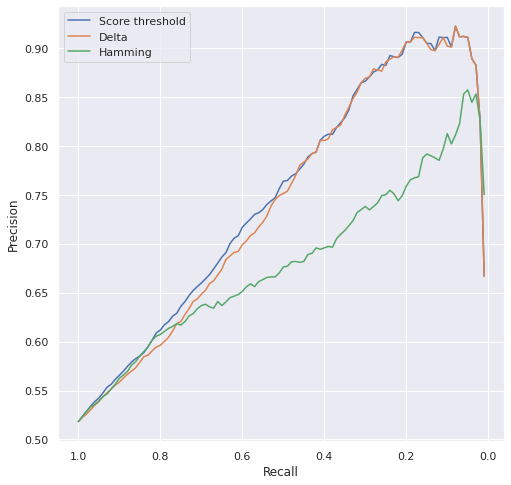

In [26]:
import seaborn as sns
sns.set_theme()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, rubq_score_accs, label='Score threshold')
ax.plot(recalls, rubq_delta_accs, label='Delta')
ax.plot(recalls, rubq_hamming_accs_10, label='Hamming')
ax.invert_xaxis()
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()

#### Limit Hamming to 5 preds

In [27]:
from scipy.spatial.distance import hamming
from itertools import combinations

distances_5 = []

for model_preds in np.array(a_model_predicts)[mask]:
    pred_distances = []
    for i, j in combinations(range(5), 2):
        pred_distances.append(hamming(model_preds[i][:5], model_preds[j][:5]))
    distances_5.append(np.mean(pred_distances))

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [28]:
recalls = np.flip(np.linspace(0.01, 1.0, 100))

rubq_hamming_accs_5 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], distances_5, recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


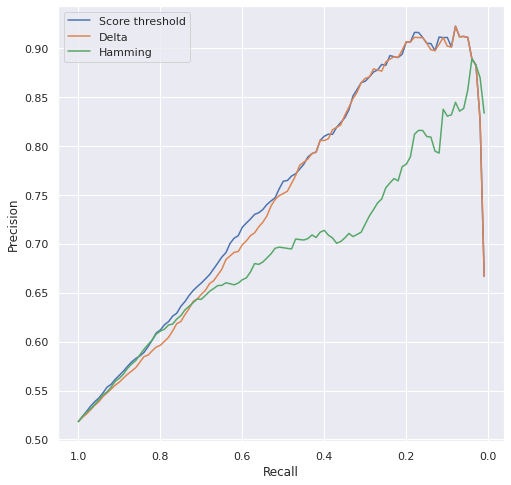

In [29]:
import seaborn as sns
sns.set_theme()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, rubq_score_accs, label='Score threshold')
ax.plot(recalls, rubq_delta_accs, label='Delta')
ax.plot(recalls, rubq_hamming_accs_5, label='Hamming')
ax.invert_xaxis()
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()

#### Limit Hamming to 3 preds

In [30]:
from scipy.spatial.distance import hamming
from itertools import combinations

distances_3 = []

for model_preds in np.array(a_model_predicts)[mask]:
    pred_distances = []
    for i, j in combinations(range(5), 2):
        pred_distances.append(hamming(model_preds[i][:3], model_preds[j][:3]))
    distances_3.append(np.mean(pred_distances))

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [31]:
recalls = np.flip(np.linspace(0.01, 1.0, 100))

rubq_hamming_accs_3 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], distances_3, recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


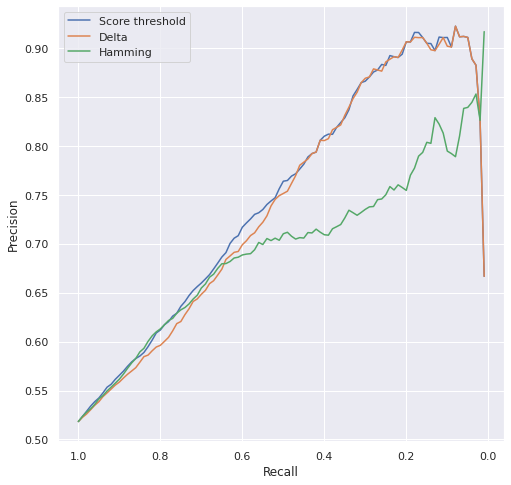

In [32]:
import seaborn as sns
sns.set_theme()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, rubq_score_accs, label='Score threshold')
ax.plot(recalls, rubq_delta_accs, label='Delta')
ax.plot(recalls, rubq_hamming_accs_3, label='Hamming')
ax.invert_xaxis()
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()

### Entropy and MI

In [33]:
MI = (entropies_of_mean) - np.array(mean_entropies)

recalls = np.flip(np.linspace(0.01, 1.0, 100))

reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(cosines_E_stds)[mask], recalls)

rubq_ee_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(mean_entropies)[mask], recalls)
rubq_pe_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(entropies_of_mean)[mask], recalls)
rubq_mi_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(MI)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this,

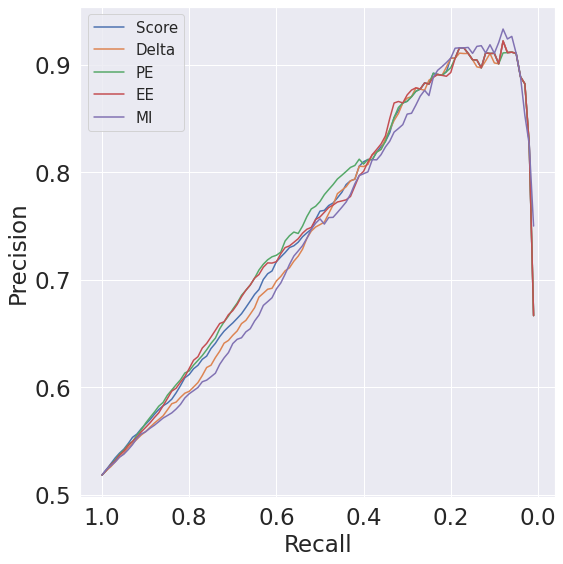

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, rubq_score_accs, label='Score')
ax.plot(recalls, rubq_delta_accs, label='Delta')
ax.plot(recalls, rubq_pe_accs, label='PE')
ax.plot(recalls, rubq_ee_accs, label='EE')
ax.plot(recalls, rubq_mi_accs, label='MI')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

#### Limit entropy calculation to 10 predictions

In [36]:
%autoreload

_, _, _, _, _, _, _, _, _, _, _, _, _, entropies_of_mean, mean_entropies, _, _, _, _, _, _, _ = eval_ensemble(questions_test, answers_test, graph_embeddings_P, graph_embeddings_Q, candidates, models, device, entropy_limit=10, temperature=0.05)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1186it [00:56, 20.97it/s]

Accuracy:  0.4881956155143339


In [37]:
MI = (entropies_of_mean) - np.array(mean_entropies)

recalls = np.flip(np.linspace(0.01, 1.0, 100))

reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(cosines_E_stds)[mask], recalls)

rubq_ee_accs_10 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(mean_entropies)[mask], recalls)
rubq_pe_accs_10 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(entropies_of_mean)[mask], recalls)
rubq_mi_accs_10 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(MI)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this,

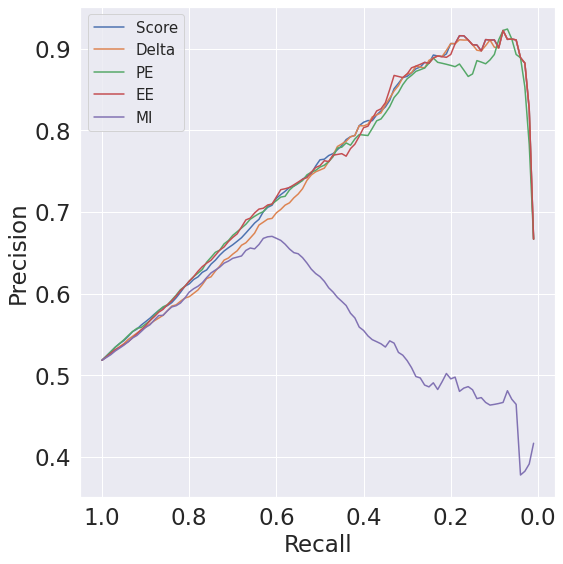

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, rubq_score_accs, label='Score')
ax.plot(recalls, rubq_delta_accs, label='Delta')
ax.plot(recalls, rubq_pe_accs_10, label='PE')
ax.plot(recalls, rubq_ee_accs_10, label='EE')
ax.plot(recalls, rubq_mi_accs_10, label='MI')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

#### Limit entropy calculation to 8 predictions

In [39]:
%autoreload

_, _, _, _, _, _, _, _, _, _, _, _, _, entropies_of_mean, mean_entropies, _, _, _, _, _, _, _ = eval_ensemble(questions_test, answers_test, graph_embeddings_P, graph_embeddings_Q, candidates, models, device, entropy_limit=8, temperature=0.05)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1186it [01:07, 17.59it/s]

Accuracy:  0.4881956155143339


In [40]:
MI = (entropies_of_mean) - np.array(mean_entropies)

recalls = np.flip(np.linspace(0.01, 1.0, 100))

reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(cosines_E_stds)[mask], recalls)

rubq_ee_accs_8 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(mean_entropies)[mask], recalls)
rubq_pe_accs_8 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(entropies_of_mean)[mask], recalls)
rubq_mi_accs_8 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(MI)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this,

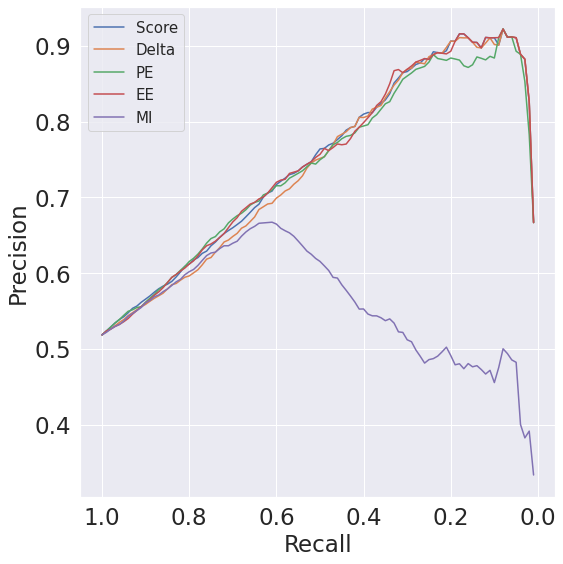

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, rubq_score_accs, label='Score')
ax.plot(recalls, rubq_delta_accs, label='Delta')
ax.plot(recalls, rubq_pe_accs_8, label='PE')
ax.plot(recalls, rubq_ee_accs_8, label='EE')
ax.plot(recalls, rubq_mi_accs_8, label='MI')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

#### Limit entropy calculation to 5 predictions

In [42]:
%autoreload

_, _, _, _, _, _, _, _, _, _, _, _, _, entropies_of_mean, mean_entropies, _, _, _, _, _, _, _ = eval_ensemble(questions_test, answers_test, graph_embeddings_P, graph_embeddings_Q, candidates, models, device, entropy_limit=5, temperature=0.05)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1186it [00:59, 19.99it/s]

Accuracy:  0.4881956155143339


In [43]:
MI = (entropies_of_mean) - np.array(mean_entropies)

recalls = np.flip(np.linspace(0.01, 1.0, 100))

reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(cosines_E_stds)[mask], recalls)

rubq_ee_accs_5 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(mean_entropies)[mask], recalls)
rubq_pe_accs_5 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(entropies_of_mean)[mask], recalls)
rubq_mi_accs_5 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(MI)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this,

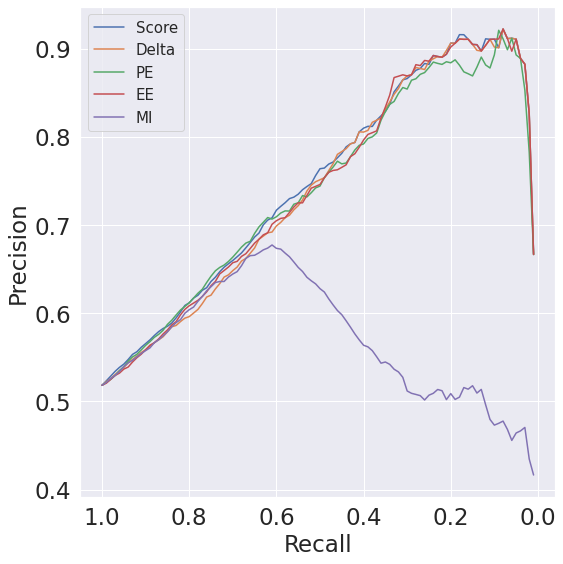

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, rubq_score_accs, label='Score')
ax.plot(recalls, rubq_delta_accs, label='Delta')
ax.plot(recalls, rubq_pe_accs_5, label='PE')
ax.plot(recalls, rubq_ee_accs_5, label='EE')
ax.plot(recalls, rubq_mi_accs_5, label='MI')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

#### Limit entropy calculation to 3 predictions

In [45]:
%autoreload

_, _, _, _, _, _, _, _, _, _, _, _, _, entropies_of_mean, mean_entropies, _, _, _, _, _, _, _ = eval_ensemble(questions_test, answers_test, graph_embeddings_P, graph_embeddings_Q, candidates, models, device, entropy_limit=3, temperature=0.05)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1186it [00:57, 20.65it/s]

Accuracy:  0.4881956155143339


In [46]:
MI = (entropies_of_mean) - np.array(mean_entropies)

recalls = np.flip(np.linspace(0.01, 1.0, 100))

reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(cosines_E_stds)[mask], recalls)

rubq_ee_accs_3 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(mean_entropies)[mask], recalls)
rubq_pe_accs_3 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(entropies_of_mean)[mask], recalls)
rubq_mi_accs_3 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(MI)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this,

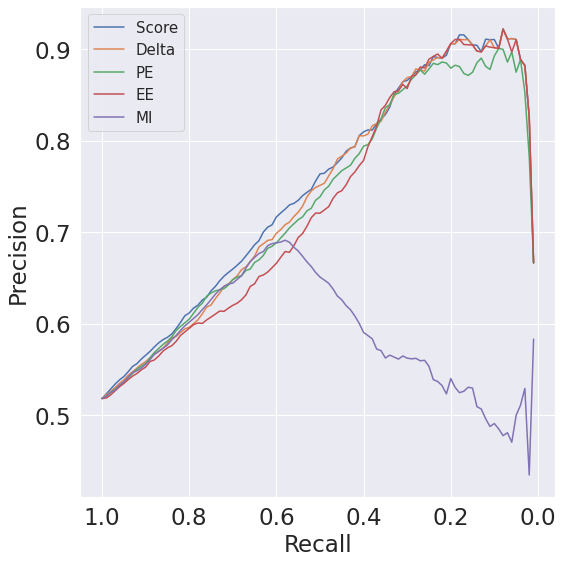

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, rubq_score_accs, label='Score')
ax.plot(recalls, rubq_delta_accs, label='Delta')
ax.plot(recalls, rubq_pe_accs_3, label='PE')
ax.plot(recalls, rubq_ee_accs_3, label='EE')
ax.plot(recalls, rubq_mi_accs_3, label='MI')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

### Delta as stat hypothesis

In [48]:
%autoreload

_, _, _, _, _, _, _, _, _, _, _, _, _, entropies_of_mean, mean_entropies, _, _, _, _, _, all_cosines, _ = eval_ensemble(questions_test, answers_test, graph_embeddings_P, graph_embeddings_Q, candidates, models, device, entropy_limit=3, temperature=0.05)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1186it [00:58, 20.36it/s]

Accuracy:  0.4881956155143339


In [49]:
from scipy.stats import ttest_ind

pvalues = []

for cos in all_cosines:
    if len(cos) == 0:
        pvalues.append(1)
    elif cos.shape[1] > 1:
        try:
            pvalues.append(ttest_ind(cos[:, 0], cos[:, 1], alternative='greater').pvalue)
        except:
            set_trace()
    else:
        pvalues.append(0)
    
recalls = np.flip(np.linspace(0.01, 1.0, 100))

rubq_delta_pvalues_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(pvalues)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


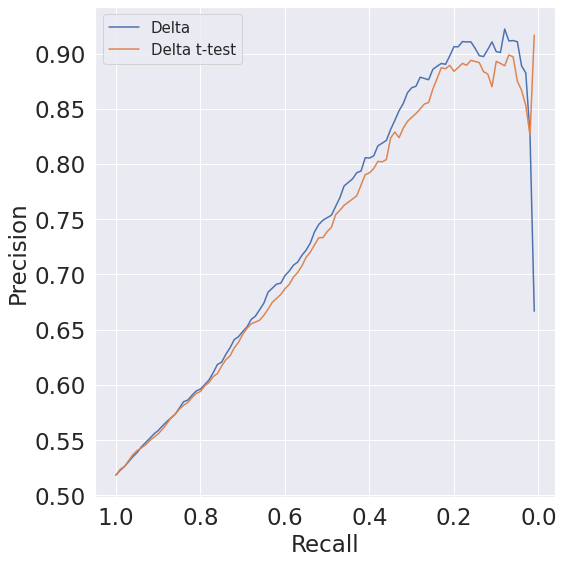

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, rubq_delta_accs, label='Delta')
ax.plot(recalls, rubq_delta_pvalues_accs, label='Delta t-test')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

In [51]:
pvalues_perm = []

for cos in all_cosines:
    if len(cos) == 0:
        pvalues_perm.append(1)
    elif cos.shape[1] > 1:
        try:
            pvalues_perm.append(ttest_ind(cos[:, 0], cos[:, 1], alternative='greater', permutations=252).pvalue)
        except:
            set_trace()
    else:
        pvalues_perm.append(0)
    
recalls = np.flip(np.linspace(0.01, 1.0, 100))

rubq_delta_pvalues_perm_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(pvalues_perm)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


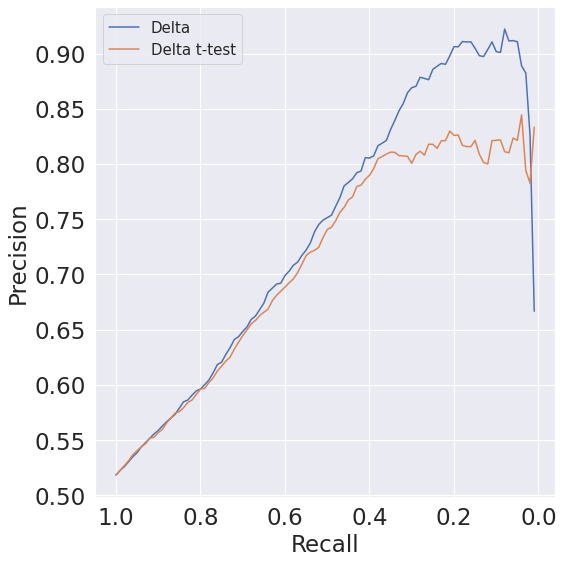

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, rubq_delta_accs, label='Delta')
ax.plot(recalls, rubq_delta_pvalues_perm_accs, label='Delta t-test')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

In [53]:
from scipy.stats import wilcoxon

wilc_pvalues = []

for cos in all_cosines:
    if len(cos) == 0:
        wilc_pvalues.append(1)
    elif cos.shape[1] > 1:
        try:
            wilc_pvalues.append(wilcoxon(cos[:, 0], cos[:, 1], alternative='greater').pvalue)
        except:
            set_trace()
    else:
        wilc_pvalues.append(0)
    
recalls = np.flip(np.linspace(0.01, 1.0, 100))

rubq_delta_wilc_pvalues_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(wilc_pvalues)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


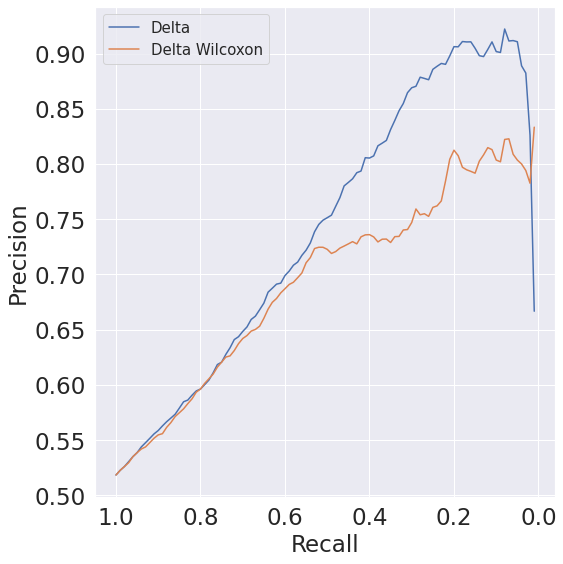

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, rubq_delta_accs, label='Delta')
ax.plot(recalls, rubq_delta_wilc_pvalues_accs, label='Delta Wilcoxon')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

In [55]:
from scipy.stats import ranksums

ranksum_pvalues = []

for cos in all_cosines:
    if len(cos) == 0:
        ranksum_pvalues.append(1)
    elif cos.shape[1] > 1:
        try:
            ranksum_pvalues.append(ranksums(cos[:, 0], cos[:, 1], alternative='greater').pvalue)
        except:
            set_trace()
    else:
        ranksum_pvalues.append(0)
    
recalls = np.flip(np.linspace(0.01, 1.0, 100))

rubq_delta_ranksum_pvalues_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_test)[mask], np.array(ranksum_pvalues)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


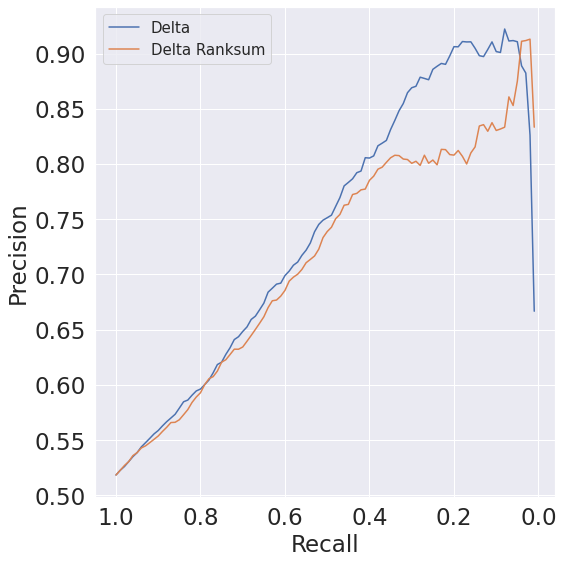

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, rubq_delta_accs, label='Delta')
ax.plot(recalls, rubq_delta_ranksum_pvalues_accs, label='Delta Ranksum')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

### Simple Questions

In [57]:
import pickle

entities = np.load('data/candidate_entities_sq_test.npy', allow_pickle=True)

with open('data/entity_subgraphs_sq_test.pickle', 'rb') as handle:
    entity_subgraphs = pickle.load(handle)

In [58]:
sq_candidates = []

for question_entities in entities:
    candidates_dict = {}
    for entity in list(question_entities.item()):
        candidates_dict[entity] = entity_subgraphs[entity]
    sq_candidates.append(candidates_dict)

In [59]:
simple_questions_test = np.load("../new_data/simple_questions_test.npy")

simple_questions_filtered = []
questions_sq = []
answers_sq = []

for e, p, a, q in tqdm(simple_questions_test):
    if e in graph_embeddings_Q and a in graph_embeddings_Q and p in graph_embeddings_P:
        simple_questions_filtered.append((e, p, a, q))
        questions_sq.append(q)
        answers_sq.append([a])

100% 4751/4751 [00:00<00:00, 177765.33it/s]


In [60]:
%autoreload

q_list, a_list, a_predicts, inv_ranks, top1_scores, top2_scores, e_stds, q_stds, p_stds, e_stds_norm, q_stds_norm, p_stds_norm, cosines_stds, entropies_of_mean, mean_entropies, acc, cosines_P_stds, cosines_Q_stds, cosines_E_stds, bad_question_ids, all_cosines, a_model_predicts = eval_ensemble(questions_sq, answers_sq, graph_embeddings_P, graph_embeddings_Q, sq_candidates, models, device, temperature=0.05)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
2438it [02:11, 18.49it/s]

Accuracy:  0.5299425758818704


In [61]:
mask = np.full_like(a_predicts, True)
mask[bad_question_ids] = False
mask = mask.astype(bool)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


### Now with score-based rejection

In [62]:
from reject import reject_by_metric

%autoreload

recalls = np.flip(np.linspace(0.01, 1.0, 100))
sq_score_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(top1_scores)[mask], recalls, reverse_order=True)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


### Now with delta-based rejection

In [63]:
top1_scores = np.array(top1_scores)
top2_scores = np.array(top2_scores)
delta = top1_scores - top2_scores

recalls = np.flip(np.linspace(0.01, 1.0, 100))
sq_delta_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(delta)[mask], recalls, reverse_order=True)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


### StD of embeddings

In [64]:
recalls = np.flip(np.linspace(0.01, 1.0, 100))

total_stds = np.array([e_stds, p_stds, q_stds]).mean(axis=0)

sq_e_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(e_stds)[mask], recalls)
sq_p_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(p_stds)[mask], recalls)
sq_q_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(q_stds)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must 

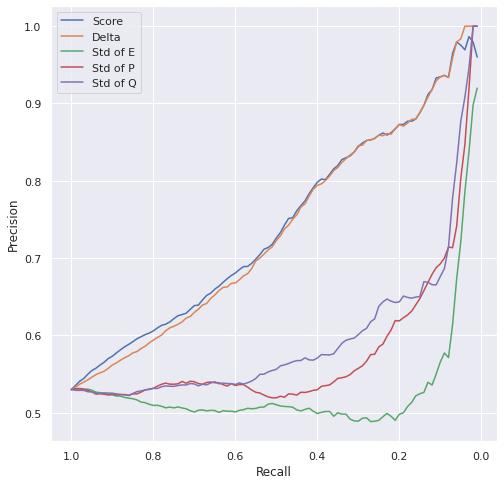

In [65]:
import seaborn as sns
sns.set_theme()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, sq_score_accs, label='Score')
ax.plot(recalls, sq_delta_accs, label='Delta')
ax.plot(recalls, sq_e_accs, label='Std of E')
ax.plot(recalls, sq_p_accs, label='Std of P')
ax.plot(recalls, sq_q_accs, label='Std of Q')
ax.invert_xaxis()
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()

### StD of Normalized embeddings

In [66]:
recalls = np.flip(np.linspace(0.01, 1.0, 100))

sq_e_accs_norm = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(e_stds_norm)[mask], recalls)
sq_p_accs_norm = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(p_stds_norm)[mask], recalls)
sq_q_accs_norm = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(q_stds_norm)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

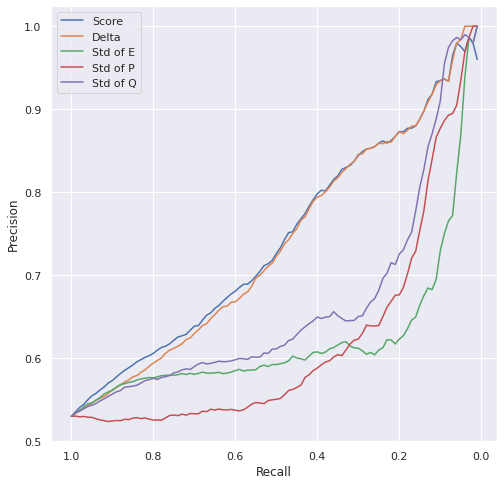

In [67]:
import seaborn as sns
sns.set_theme()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, sq_score_accs, label='Score')
ax.plot(recalls, sq_delta_accs, label='Delta')
ax.plot(recalls, sq_e_accs_norm, label='Std of E')
ax.plot(recalls, sq_p_accs_norm, label='Std of P')
ax.plot(recalls, sq_q_accs_norm, label='Std of Q')
ax.invert_xaxis()
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()

### StD of scores

In [68]:
recalls = np.flip(np.linspace(0.01, 1.0, 100))

sq_cosine_e_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(cosines_E_stds)[mask], recalls)
sq_cosine_p_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(cosines_P_stds)[mask], recalls)
sq_cosine_q_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(cosines_Q_stds)[mask], recalls)
sq_cosine_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(cosines_stds)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

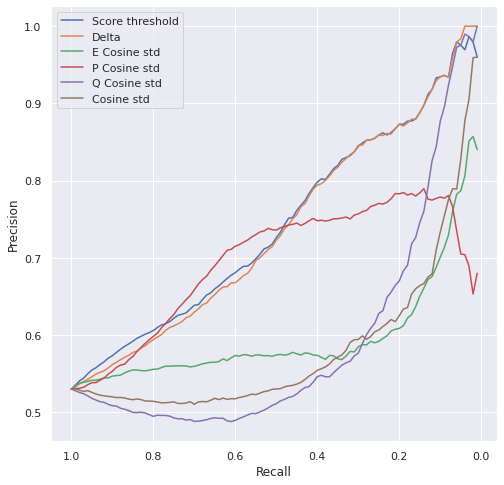

In [69]:
import seaborn as sns
sns.set_theme()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, sq_score_accs, label='Score threshold')
ax.plot(recalls, sq_delta_accs, label='Delta')
ax.plot(recalls, sq_cosine_e_accs, label='E Cosine std')
ax.plot(recalls, sq_cosine_p_accs, label='P Cosine std')
ax.plot(recalls, sq_cosine_q_accs, label='Q Cosine std')
ax.plot(recalls, sq_cosine_accs, label='Cosine std')
ax.invert_xaxis()
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()

### Hamming distance

In [70]:
from scipy.spatial.distance import hamming
from itertools import combinations

distances = []

for model_preds in np.array(a_model_predicts)[mask]:
    pred_distances = []
    for i, j in combinations(range(5), 2):
        pred_distances.append(hamming(model_preds[i], model_preds[j]))
    distances.append(np.mean(pred_distances))

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [71]:
recalls = np.flip(np.linspace(0.01, 1.0, 100))

sq_hamming_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], distances, recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


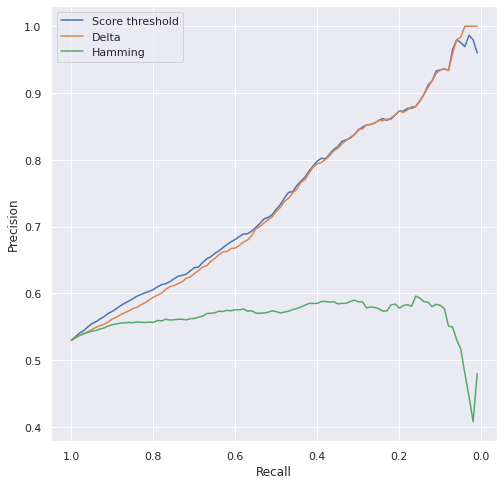

In [72]:
import seaborn as sns
sns.set_theme()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, sq_score_accs, label='Score threshold')
ax.plot(recalls, sq_delta_accs, label='Delta')
ax.plot(recalls, sq_hamming_accs, label='Hamming')
ax.invert_xaxis()
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()

#### Limit Hamming to 10 preds

In [73]:
from scipy.spatial.distance import hamming
from itertools import combinations

distances_10 = []

for model_preds in np.array(a_model_predicts)[mask]:
    pred_distances = []
    for i, j in combinations(range(5), 2):
        pred_distances.append(hamming(model_preds[i][:10], model_preds[j][:10]))
    distances_10.append(np.mean(pred_distances))

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [74]:
recalls = np.flip(np.linspace(0.01, 1.0, 100))

sq_hamming_accs_10 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], distances_10, recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


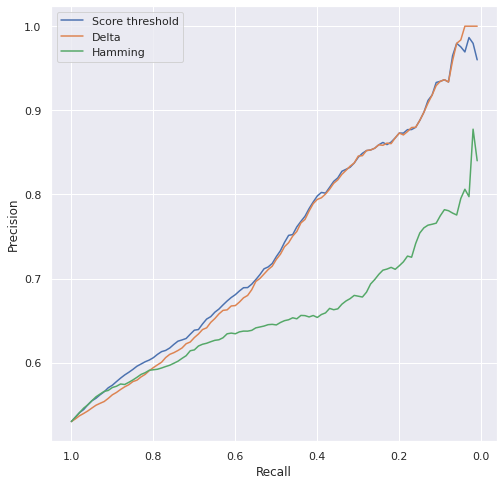

In [75]:
import seaborn as sns
sns.set_theme()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, sq_score_accs, label='Score threshold')
ax.plot(recalls, sq_delta_accs, label='Delta')
ax.plot(recalls, sq_hamming_accs_10, label='Hamming')
ax.invert_xaxis()
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()

#### Limit Hamming to 5 preds

In [76]:
from scipy.spatial.distance import hamming
from itertools import combinations

distances_5 = []

for model_preds in np.array(a_model_predicts)[mask]:
    pred_distances = []
    for i, j in combinations(range(5), 2):
        pred_distances.append(hamming(model_preds[i][:5], model_preds[j][:5]))
    distances_5.append(np.mean(pred_distances))

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [77]:
recalls = np.flip(np.linspace(0.01, 1.0, 100))

sq_hamming_accs_5 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], distances_5, recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


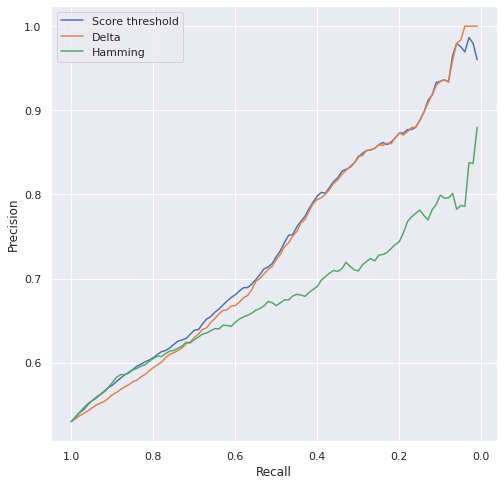

In [78]:
import seaborn as sns
sns.set_theme()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, sq_score_accs, label='Score threshold')
ax.plot(recalls, sq_delta_accs, label='Delta')
ax.plot(recalls, sq_hamming_accs_5, label='Hamming')
ax.invert_xaxis()
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()

#### Limit Hamming to 3 preds

In [79]:
from scipy.spatial.distance import hamming
from itertools import combinations

distances_3 = []

for model_preds in np.array(a_model_predicts)[mask]:
    pred_distances = []
    for i, j in combinations(range(5), 2):
        pred_distances.append(hamming(model_preds[i][:3], model_preds[j][:3]))
    distances_3.append(np.mean(pred_distances))

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [80]:
recalls = np.flip(np.linspace(0.01, 1.0, 100))

sq_hamming_accs_3 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], distances_3, recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


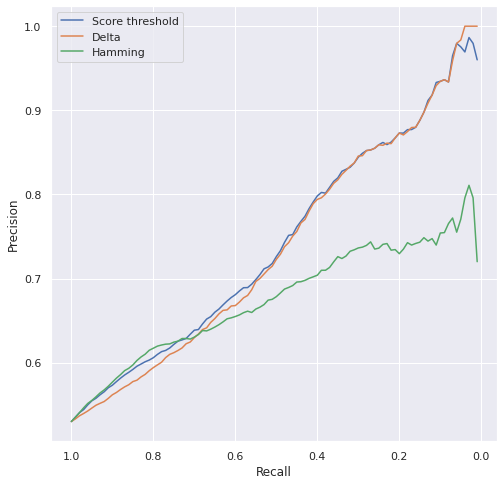

In [81]:
import seaborn as sns
sns.set_theme()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, sq_score_accs, label='Score threshold')
ax.plot(recalls, sq_delta_accs, label='Delta')
ax.plot(recalls, sq_hamming_accs_3, label='Hamming')
ax.invert_xaxis()
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()

### Entropy and MI

In [82]:
MI = (entropies_of_mean) - np.array(mean_entropies)

recalls = np.flip(np.linspace(0.01, 1.0, 100))

sq_ee_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(mean_entropies)[mask], recalls)
sq_pe_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(entropies_of_mean)[mask], recalls)
sq_mi_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(MI)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must 

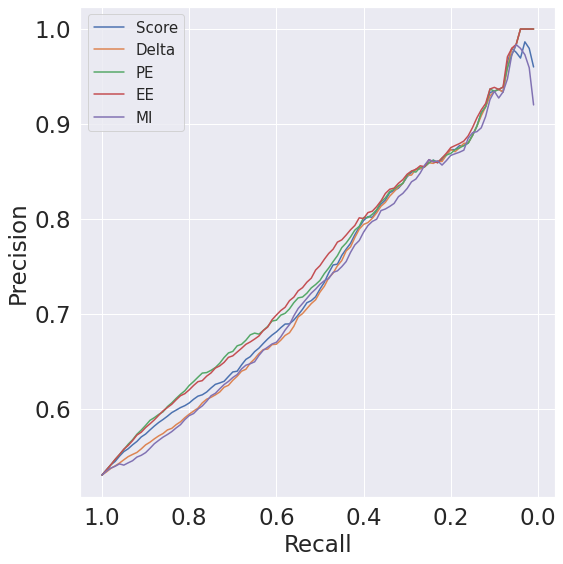

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, sq_score_accs, label='Score')
ax.plot(recalls, sq_delta_accs, label='Delta')
ax.plot(recalls, sq_pe_accs, label='PE')
ax.plot(recalls, sq_ee_accs, label='EE')
ax.plot(recalls, sq_mi_accs, label='MI')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

#### Limit entropy calculation to 10 predictions

In [84]:
%autoreload

_, _, _, _, _, _, _, _, _, _, _, _, _, entropies_of_mean, mean_entropies, _, _, _, _, _, _, _ = eval_ensemble(questions_sq, answers_sq, graph_embeddings_P, graph_embeddings_Q, sq_candidates, models, device, entropy_limit=10, temperature=0.05)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
2438it [02:12, 18.34it/s]

Accuracy:  0.5299425758818704


In [85]:
MI = (entropies_of_mean) - np.array(mean_entropies)

recalls = np.flip(np.linspace(0.01, 1.0, 100))

reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(cosines_E_stds)[mask], recalls)

sq_ee_accs_10 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(mean_entropies)[mask], recalls)
sq_pe_accs_10 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(entropies_of_mean)[mask], recalls)
sq_mi_accs_10 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(MI)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this,

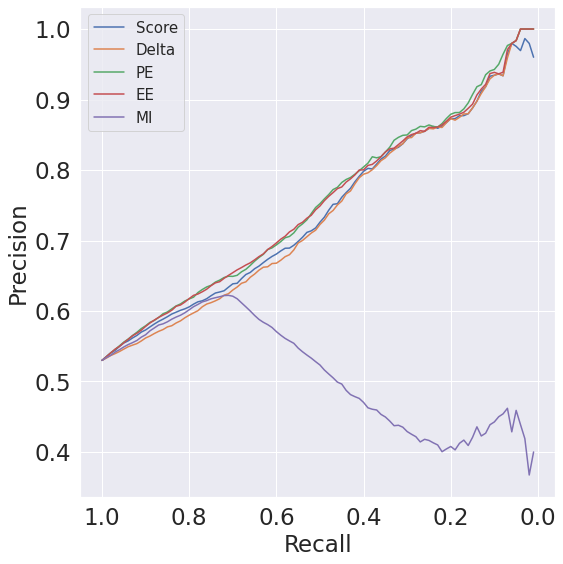

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, sq_score_accs, label='Score')
ax.plot(recalls, sq_delta_accs, label='Delta')
ax.plot(recalls, sq_pe_accs_10, label='PE')
ax.plot(recalls, sq_ee_accs_10, label='EE')
ax.plot(recalls, sq_mi_accs_10, label='MI')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

#### Limit entropy calculation to 8 predictions

In [87]:
%autoreload

_, _, _, _, _, _, _, _, _, _, _, _, _, entropies_of_mean, mean_entropies, _, _, _, _, _, _, _ = eval_ensemble(questions_sq, answers_sq, graph_embeddings_P, graph_embeddings_Q, sq_candidates, models, device, entropy_limit=8, temperature=0.05)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
2438it [02:12, 18.39it/s]

Accuracy:  0.5299425758818704


In [88]:
MI = (entropies_of_mean) - np.array(mean_entropies)

recalls = np.flip(np.linspace(0.01, 1.0, 100))

reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(cosines_E_stds)[mask], recalls)

sq_ee_accs_8 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(mean_entropies)[mask], recalls)
sq_pe_accs_8 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(entropies_of_mean)[mask], recalls)
sq_mi_accs_8 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(MI)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this,

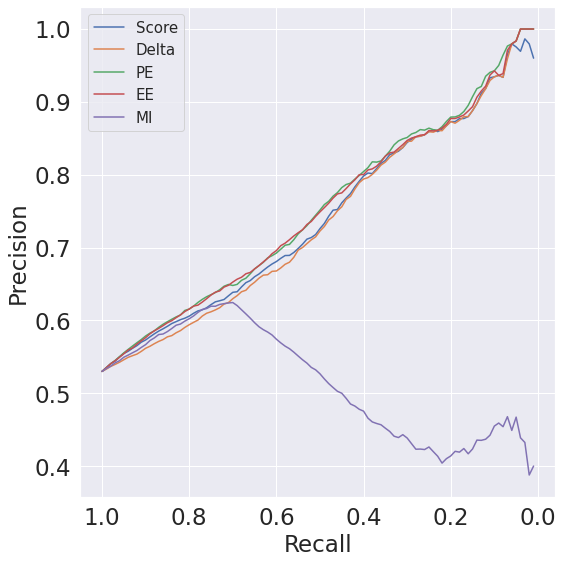

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, sq_score_accs, label='Score')
ax.plot(recalls, sq_delta_accs, label='Delta')
ax.plot(recalls, sq_pe_accs_8, label='PE')
ax.plot(recalls, sq_ee_accs_8, label='EE')
ax.plot(recalls, sq_mi_accs_8, label='MI')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

#### Limit entropy calculation to 5 predictions

In [90]:
%autoreload

_, _, _, _, _, _, _, _, _, _, _, _, _, entropies_of_mean, mean_entropies, _, _, _, _, _, _, _ = eval_ensemble(questions_sq, answers_sq, graph_embeddings_P, graph_embeddings_Q, sq_candidates, models, device, entropy_limit=5, temperature=0.05)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
2438it [02:21, 17.26it/s]

Accuracy:  0.5299425758818704


In [91]:
MI = (entropies_of_mean) - np.array(mean_entropies)

recalls = np.flip(np.linspace(0.01, 1.0, 100))

reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(cosines_E_stds)[mask], recalls)

sq_ee_accs_5 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(mean_entropies)[mask], recalls)
sq_pe_accs_5 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(entropies_of_mean)[mask], recalls)
sq_mi_accs_5 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(MI)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this,

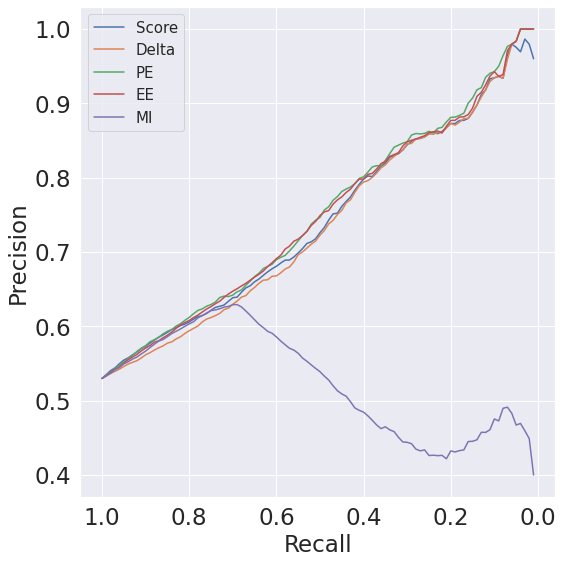

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, sq_score_accs, label='Score')
ax.plot(recalls, sq_delta_accs, label='Delta')
ax.plot(recalls, sq_pe_accs_5, label='PE')
ax.plot(recalls, sq_ee_accs_5, label='EE')
ax.plot(recalls, sq_mi_accs_5, label='MI')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

#### Limit entropy calculation to 3 predictions

In [93]:
%autoreload

_, _, _, _, _, _, _, _, _, _, _, _, _, entropies_of_mean, mean_entropies, _, _, _, _, _, _, _ = eval_ensemble(questions_sq, answers_sq, graph_embeddings_P, graph_embeddings_Q, sq_candidates, models, device, entropy_limit=3, temperature=0.05)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
2438it [02:11, 18.50it/s]

Accuracy:  0.5299425758818704


In [94]:
MI = (entropies_of_mean) - np.array(mean_entropies)

recalls = np.flip(np.linspace(0.01, 1.0, 100))

reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(cosines_E_stds)[mask], recalls)

sq_ee_accs_3 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(mean_entropies)[mask], recalls)
sq_pe_accs_3 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(entropies_of_mean)[mask], recalls)
sq_mi_accs_3 = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(MI)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this,

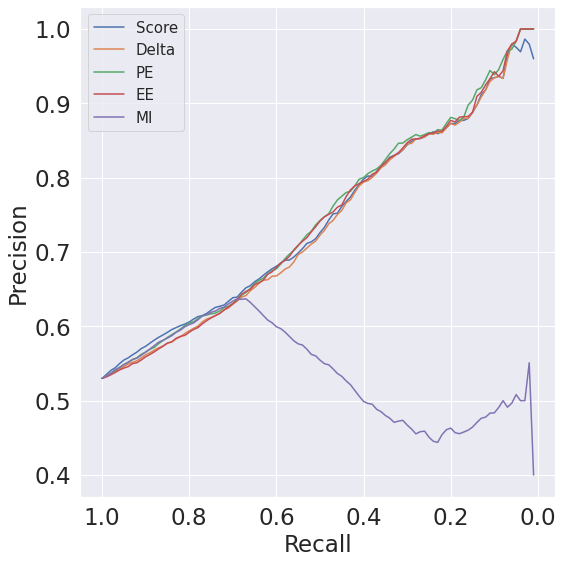

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, sq_score_accs, label='Score')
ax.plot(recalls, sq_delta_accs, label='Delta')
ax.plot(recalls, sq_pe_accs_3, label='PE')
ax.plot(recalls, sq_ee_accs_3, label='EE')
ax.plot(recalls, sq_mi_accs_3, label='MI')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

### Stat Delta

In [96]:
%autoreload

_, _, _, _, _, _, _, _, _, _, _, _, _, entropies_of_mean, mean_entropies, _, _, _, _, _, all_cosines, _ = eval_ensemble(questions_sq, answers_sq, graph_embeddings_P, graph_embeddings_Q, sq_candidates, models, device, temperature=0.05)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
2438it [02:17, 17.75it/s]

Accuracy:  0.5299425758818704


In [97]:
from scipy.stats import ttest_ind

pvalues = []

for cos in all_cosines:
    if len(cos) == 0:
        pvalues.append(1)
    elif cos.shape[1] > 1:
        try:
            pvalues.append(ttest_ind(cos[:, 0], cos[:, 1], alternative='greater').pvalue)
        except:
            set_trace()
    else:
        pvalues.append(0)
    
recalls = np.flip(np.linspace(0.01, 1.0, 100))

sq_delta_pvalues_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(pvalues)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


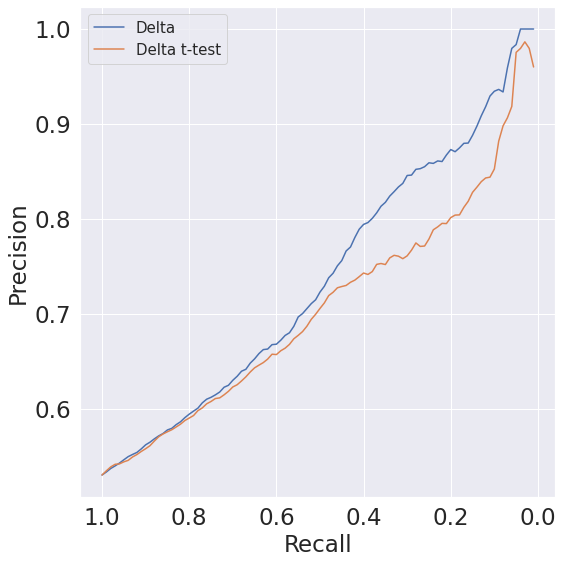

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, sq_delta_accs, label='Delta')
ax.plot(recalls, sq_delta_pvalues_accs, label='Delta t-test')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

In [99]:
pvalues_perm = []

for cos in all_cosines:
    if len(cos) == 0:
        pvalues_perm.append(1)
    elif cos.shape[1] > 1:
        try:
            pvalues_perm.append(ttest_ind(cos[:, 0], cos[:, 1], alternative='greater', permutations=252).pvalue)
        except:
            set_trace()
    else:
        pvalues_perm.append(0)
    
recalls = np.flip(np.linspace(0.01, 1.0, 100))

sq_delta_pvalues_perm_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(pvalues_perm)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


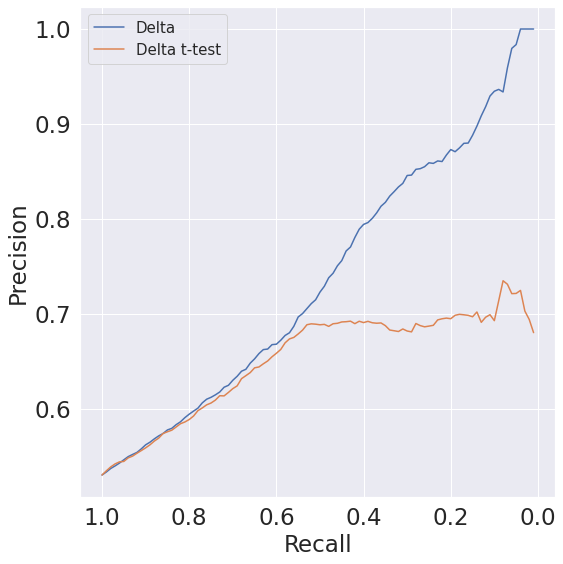

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, sq_delta_accs, label='Delta')
ax.plot(recalls, sq_delta_pvalues_perm_accs, label='Delta t-test')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

In [101]:
from scipy.stats import wilcoxon

wilc_pvalues = []

for cos in all_cosines:
    if len(cos) == 0:
        wilc_pvalues.append(1)
    elif cos.shape[1] > 1:
        try:
            wilc_pvalues.append(wilcoxon(cos[:, 0], cos[:, 1], alternative='greater').pvalue)
        except:
            set_trace()
    else:
        wilc_pvalues.append(0)
    
recalls = np.flip(np.linspace(0.01, 1.0, 100))

sq_delta_wilc_pvalues_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(wilc_pvalues)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


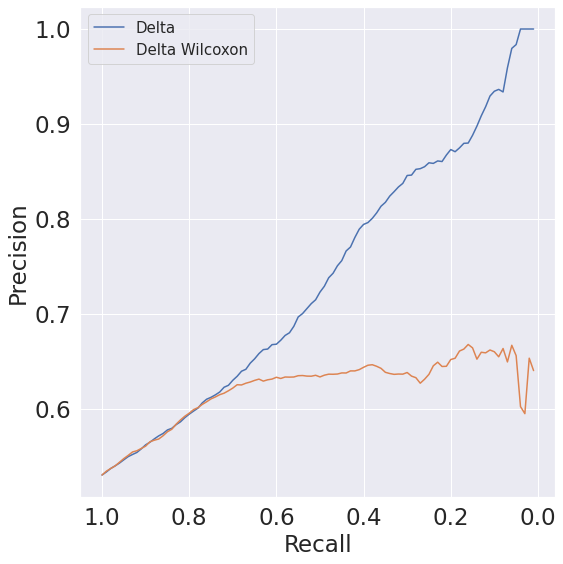

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, sq_delta_accs, label='Delta')
ax.plot(recalls, sq_delta_wilc_pvalues_accs, label='Delta Wilcoxon')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

In [103]:
from scipy.stats import ranksums

ranksum_pvalues = []

for cos in all_cosines:
    if len(cos) == 0:
        ranksum_pvalues.append(1)
    elif cos.shape[1] > 1:
        try:
            ranksum_pvalues.append(ranksums(cos[:, 0], cos[:, 1], alternative='greater').pvalue)
        except:
            set_trace()
    else:
        ranksum_pvalues.append(0)
    
recalls = np.flip(np.linspace(0.01, 1.0, 100))

sq_delta_ranksum_pvalues_accs = reject_by_metric(np.array(a_predicts)[mask], np.array(answers_sq)[mask], np.array(ranksum_pvalues)[mask], recalls)

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


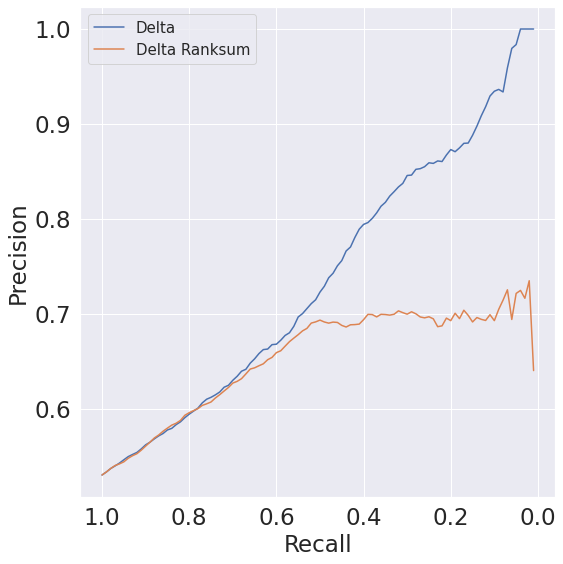

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

sns.set_style()

rc('text', usetex=False)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('legend', fontsize=15)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(recalls, sq_delta_accs, label='Delta')
ax.plot(recalls, sq_delta_ranksum_pvalues_accs, label='Delta Ranksum')
ax.invert_xaxis()
ax.set_xlabel('Recall', fontsize=23)
ax.set_ylabel('Precision', fontsize=23)
ax.legend()
plt.tight_layout()

In [105]:
from sklearn.metrics import auc

rubq_rejected_accs = [
    rubq_score_accs,
    rubq_delta_accs,
    rubq_e_accs,
    rubq_p_accs,
    rubq_q_accs,
    rubq_e_accs_norm,
    rubq_p_accs_norm,
    rubq_q_accs_norm,
    rubq_cosine_e_accs,
    rubq_cosine_p_accs,
    rubq_cosine_q_accs,
    rubq_cosine_accs,
    rubq_hamming_accs,
    rubq_hamming_accs_10,
    rubq_hamming_accs_5,
    rubq_hamming_accs_3,
    rubq_ee_accs,
    rubq_pe_accs,
    rubq_mi_accs,
    rubq_ee_accs_10,
    rubq_pe_accs_10,
    rubq_mi_accs_10,
    rubq_ee_accs_8,
    rubq_pe_accs_8,
    rubq_mi_accs_8,
    rubq_ee_accs_5,
    rubq_pe_accs_5,
    rubq_mi_accs_5,
    rubq_ee_accs_3,
    rubq_pe_accs_3,
    rubq_mi_accs_3,
    rubq_delta_pvalues_accs,
    rubq_delta_pvalues_perm_accs,
    rubq_delta_wilc_pvalues_accs,
    rubq_delta_ranksum_pvalues_accs
]

rubq_rejected_acc_names = [
    'rubq_score_accs',
    'rubq_delta_accs',
    'rubq_e_accs',
    'rubq_p_accs',
    'rubq_q_accs',
    'rubq_e_accs_norm',
    'rubq_p_accs_norm',
    'rubq_q_accs_norm',
    'rubq_cosine_e_accs',
    'rubq_cosine_p_accs',
    'rubq_cosine_q_accs',
    'rubq_cosine_accs',
    'rubq_hamming_accs',
    'rubq_hamming_accs_10',
    'rubq_hamming_accs_5',
    'rubq_hamming_accs_3',
    'rubq_ee_accs',
    'rubq_pe_accs',
    'rubq_mi_accs',
    'rubq_ee_accs_10',
    'rubq_pe_accs_10',
    'rubq_mi_accs_10',
    'rubq_ee_accs_8',
    'rubq_pe_accs_8',
    'rubq_mi_accs_8',
    'rubq_ee_accs_5',
    'rubq_pe_accs_5',
    'rubq_mi_accs_5',
    'rubq_ee_accs_3',
    'rubq_pe_accs_3',
    'rubq_mi_accs_3',
    'rubq_delta_pvalues_accs',
    'rubq_delta_pvalues_perm_accs',
    'rubq_delta_wilc_pvalues_accs',
    'rubq_delta_ranksum_pvalues_accs'
]

rubq_aucs = []
for acc_ary in rubq_rejected_accs:
    rubq_aucs.append(auc(recalls, acc_ary))
    
sorting = np.flip(np.argsort(rubq_aucs))

sorted_aucs = np.array(rubq_aucs)[sorting]
sorted_names = np.array(rubq_rejected_acc_names)[sorting]

for rej_auc, name in zip(sorted_aucs, sorted_names):
    print(name, rej_auc)

rubq_pe_accs 0.7440382389612263
rubq_ee_accs 0.7414931499610473
rubq_ee_accs_10 0.7399851525623693
rubq_score_accs 0.7394314430247566
rubq_ee_accs_8 0.7392458561196934
rubq_pe_accs_10 0.7346879692488072
rubq_ee_accs_5 0.7344947689155794
rubq_pe_accs_8 0.7338084914867506
rubq_delta_accs 0.7337265084285092
rubq_pe_accs_5 0.7319686320841284
rubq_mi_accs 0.730714230595734
rubq_pe_accs_3 0.7260018682206668
rubq_delta_pvalues_accs 0.7239866271610734
rubq_ee_accs_3 0.7215427213728869
rubq_delta_ranksum_pvalues_accs 0.7070228780126201
rubq_delta_pvalues_perm_accs 0.7048782723712429
rubq_delta_wilc_pvalues_accs 0.686078225637213
rubq_hamming_accs_3 0.6860274712596063
rubq_hamming_accs_5 0.6834175398332324
rubq_hamming_accs 0.6743680228021199
rubq_hamming_accs_10 0.6723937228715187
rubq_cosine_p_accs 0.6471876052084079
rubq_e_accs 0.6332652408528658
rubq_p_accs 0.6199748997960577
rubq_q_accs 0.6199282366805209
rubq_cosine_accs 0.6186084518509394
rubq_q_accs_norm 0.6076617858385118
rubq_p_accs_no

In [106]:
from sklearn.metrics import auc

sq_rejected_accs = [
    sq_score_accs,
    sq_delta_accs,
    sq_e_accs,
    sq_p_accs,
    sq_q_accs,
    sq_e_accs_norm,
    sq_p_accs_norm,
    sq_q_accs_norm,
    sq_cosine_e_accs,
    sq_cosine_p_accs,
    sq_cosine_q_accs,
    sq_cosine_accs,
    sq_hamming_accs,
    sq_hamming_accs_10,
    sq_hamming_accs_5,
    sq_hamming_accs_3,
    sq_ee_accs,
    sq_pe_accs,
    sq_mi_accs,
    sq_ee_accs_10,
    sq_pe_accs_10,
    sq_mi_accs_10,
    sq_ee_accs_8,
    sq_pe_accs_8,
    sq_mi_accs_8,
    sq_ee_accs_5,
    sq_pe_accs_5,
    sq_mi_accs_5,
    sq_ee_accs_3,
    sq_pe_accs_3,
    sq_mi_accs_3,
    sq_delta_pvalues_accs,
    sq_delta_pvalues_perm_accs,
    sq_delta_wilc_pvalues_accs,
    sq_delta_ranksum_pvalues_accs
]

sq_rejected_acc_names = [
    'sq_score_accs',
    'sq_delta_accs',
    'sq_e_accs',
    'sq_p_accs',
    'sq_q_accs',
    'sq_e_accs_norm',
    'sq_p_accs_norm',
    'sq_q_accs_norm',
    'sq_cosine_e_accs',
    'sq_cosine_p_accs',
    'sq_cosine_q_accs',
    'sq_cosine_accs',
    'sq_hamming_accs',
    'sq_hamming_accs_10',
    'sq_hamming_accs_5',
    'sq_hamming_accs_3',
    'sq_ee_accs',
    'sq_pe_accs',
    'sq_mi_accs',
    'sq_ee_accs_10',
    'sq_pe_accs_10',
    'sq_mi_accs_10',
    'sq_ee_accs_8',
    'sq_pe_accs_8',
    'sq_mi_accs_8',
    'sq_ee_accs_5',
    'sq_pe_accs_5',
    'sq_mi_accs_5',
    'sq_ee_accs_3',
    'sq_pe_accs_3',
    'sq_mi_accs_3',
    'sq_delta_pvalues_accs',
    'sq_delta_pvalues_perm_accs',
    'sq_delta_wilc_pvalues_accs',
    'sq_delta_ranksum_pvalues_accs'
]

sq_aucs = []
for acc_ary in sq_rejected_accs:
    sq_aucs.append(auc(recalls, acc_ary))
    
sorting = np.flip(np.argsort(sq_aucs))

sorted_aucs = np.array(sq_aucs)[sorting]
sorted_names = np.array(sq_rejected_acc_names)[sorting]

for rej_auc, name in zip(sorted_aucs, sorted_names):
    print(name, rej_auc)

sq_pe_accs_10 0.7442519356749745
sq_pe_accs_8 0.743748210179753
sq_ee_accs 0.7432700303180625
sq_ee_accs_10 0.7421791221883729
sq_pe_accs_5 0.7415705162259716
sq_ee_accs_8 0.7415305768530137
sq_pe_accs 0.7411760011328532
sq_ee_accs_5 0.7387716885135853
sq_pe_accs_3 0.7361325381224703
sq_score_accs 0.7327996280491594
sq_ee_accs_3 0.7319464468164187
sq_delta_accs 0.7283120305460522
sq_mi_accs 0.7249961948219542
sq_delta_pvalues_accs 0.6975432456828059
sq_cosine_p_accs 0.6857273504027341
sq_hamming_accs_3 0.667574251078309
sq_hamming_accs_5 0.6675149593916613
sq_q_accs_norm 0.6538441894160217
sq_hamming_accs_10 0.648833762427364
sq_delta_ranksum_pvalues_accs 0.64718879706872
sq_delta_pvalues_perm_accs 0.6450172703960216
sq_delta_wilc_pvalues_accs 0.614938039871647
sq_e_accs_norm 0.6131673118142067
sq_p_accs_norm 0.609329577130226
sq_cosine_e_accs 0.5889535474416286
sq_q_accs 0.5864985287207644
sq_cosine_q_accs 0.5829108894651517
sq_cosine_accs 0.573153299188233
sq_p_accs 0.568998586693336